# AR モデル

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# comment out below
import json
def dict2rc(dict): return {f'{k1}.{k2}': v for k1,d in dict.items() for k2, v in d.items()}
with open('mpl_rc.json') as f:
    plt.rcParams.update(dict2rc(json.load(f)))
plt.style.use('dracula')

In [9]:
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
isinstance(np.array([1,2]), np.ndarray)

True

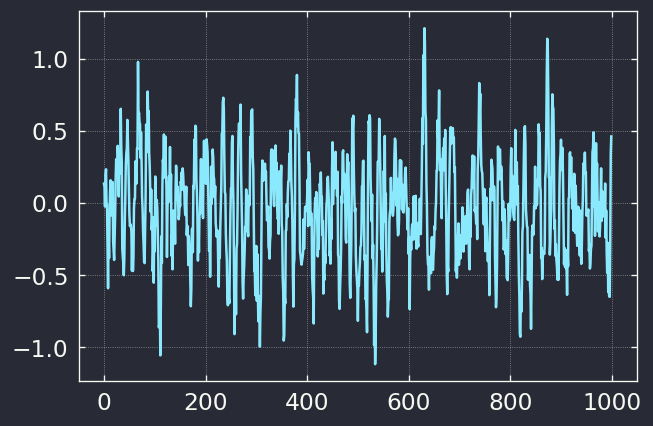

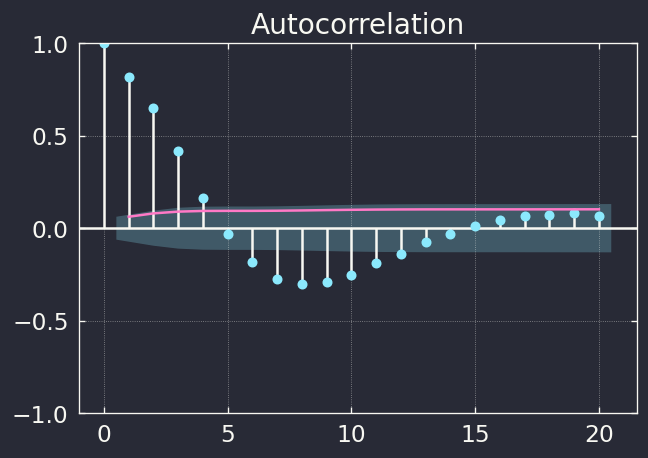

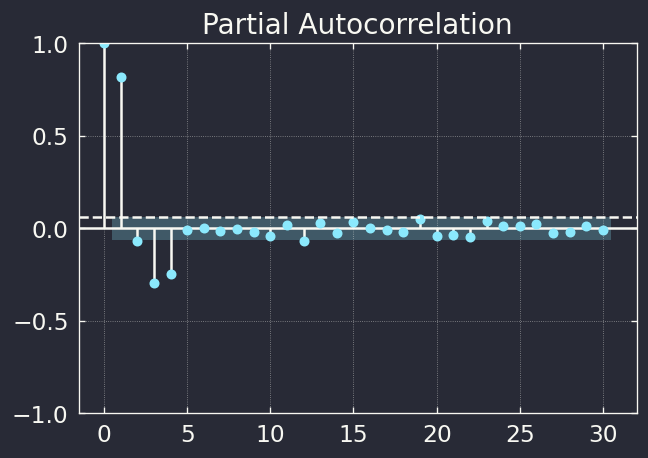

In [4]:
# AR的な時系列を生成
def generate_ar_time_series(T, coefs, sigma=1.0, seed=23):
    # coef: AR(p)のパラメータ; p=len(coefs)
    # sigma: WN(sigma^2); ここでは正規乱数を使う

    if not isinstance(coefs, np.ndarray):
        coefs = np.array(coefs)

    p = len(coefs)
    np.random.seed(seed)
    x = np.random.normal(loc=0, scale=sigma, size=T)
    for t in range(1,T):
        x[t] += np.sum(coefs[min(t,p)-1::-1] * x[max(0,t-p):t])
    return x

x = generate_ar_time_series(1000, [0.8, 0.3, -0.1, -0.3], sigma=0.2)
plt.plot(x)
lags = 20
plot_acf(x, lags=lags);
plt.plot(range(1, lags+1), np.sqrt(np.cumsum(np.power(acf(x[1:], nlags=lags),2))[:-1] / len(x[1:])) * 1.96)
plot_pacf(x); plt.axhline(1.96 / np.sqrt(len(x[1:])), linestyle='--');

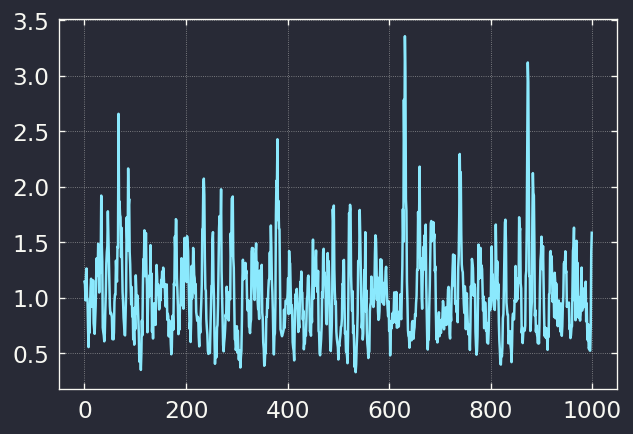

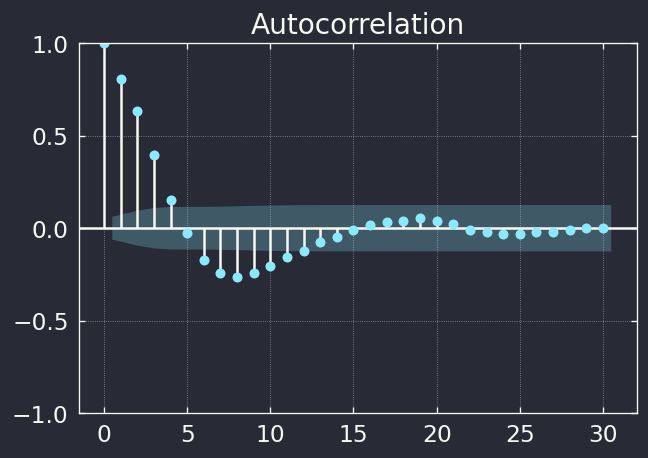

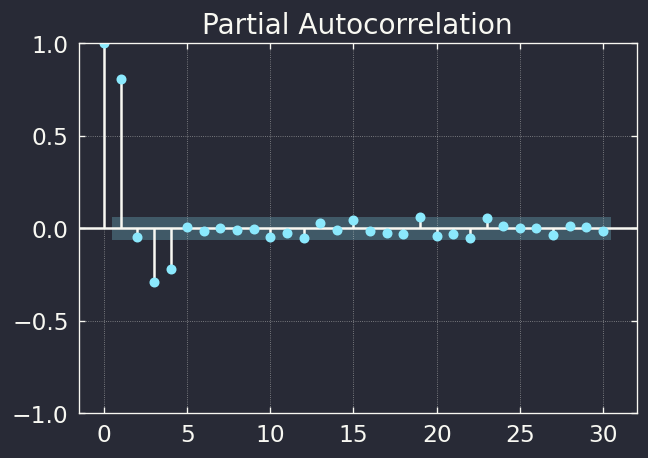

In [5]:
plt.plot(np.exp(x))
plot_acf(np.exp(x));
plot_pacf(np.exp(x));

In [6]:
adfuller(x)

(-15.701281466703495,
 1.3951259501357002e-28,
 3,
 996,
 {'1%': -3.4369325637409154,
  '5%': -2.8644462162311934,
  '10%': -2.568317409920808},
 -444.9425309753717)

In [7]:
adfuller(np.exp(x))

(-15.232683335306973,
 5.294536793134007e-28,
 3,
 996,
 {'1%': -3.4369325637409154,
  '5%': -2.8644462162311934,
  '10%': -2.568317409920808},
 -225.7452283084233)

In [26]:
n_train = int(len(x) * 0.75)
x_train = x[:n_train]
ar_lags = ar_select_order(x_train, maxlag=5, glob=True, ic='aic').ar_lags
result = AutoReg(x_train, lags=ar_lags).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  750
Model:                     AutoReg(4)   Log Likelihood                 180.405
Method:               Conditional MLE   S.D. of innovations              0.190
Date:                Mon, 05 Jun 2023   AIC                           -348.810
Time:                        16:07:02   BIC                           -321.122
Sample:                             4   HQIC                          -338.139
                                  750                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0112      0.007     -1.599      0.110      -0.025       0.003
y.L1           0.7687      0.035     21.805      0.000       0.700       0.838
y.L2           0.2766      0.045      6.145      0.000       0.188       0.365
y.L3          -0.0796      0.045     -1.769      0.077      -0.168       0.009
y.L4          -0.2710      0.035     -7.685      0.000      -0.340      -0.202
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0637           -0.4200j            1.1436           -0.0598
AR.2            1.0637           +0.4200j            1.1436            0.0598
AR.3           -1.2106           -1.1647j            1.6799           -0.3781
AR.4           -1.2106           +1.1647j            1.6799            0.3781
-----------------------------------------------------------------------------
"""

(750.0, 1000.0)

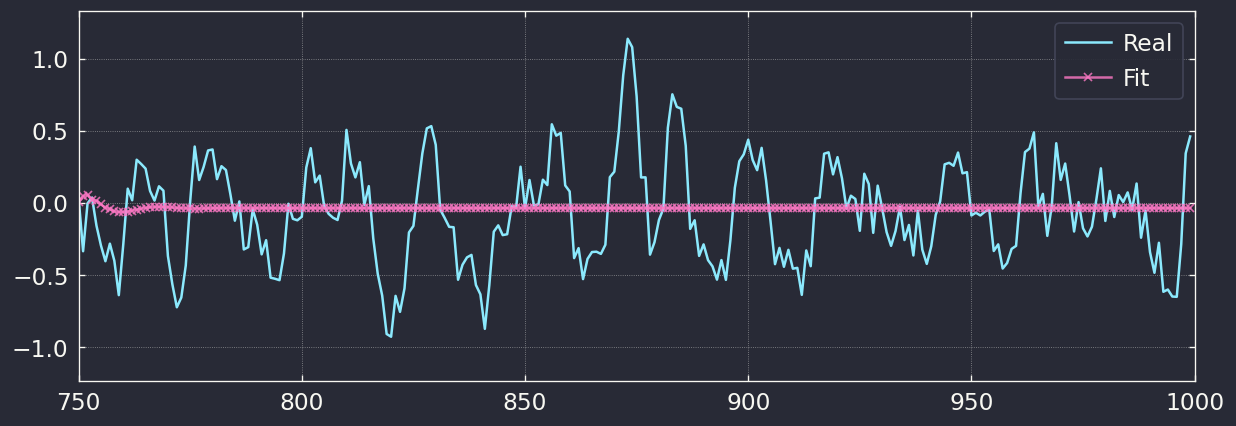

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(x, label='Real')
plt.plot(result.predict(start=0, end=len(x)-1), label='Fit', linestyle='-', alpha=0.8, marker='x', markersize=5)
plt.legend()
plt.xlim(n_train,len(x))